In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy

In [4]:
df_feb = pd.read_parquet("yellow_tripdata_2022-02.parquet")
df_jun = pd.read_parquet("yellow_tripdata_2022-06.parquet")
df = pd.concat((df_jun, df_feb))
df.describe()
len(df)

6537555

In [5]:
# Pre-processing
df = df[(df['trip_distance'] > 1) & (df['passenger_count'] > 0) & (df['fare_amount']>= 2.5) & (df['tip_amount']<=200) & 
        (df['total_amount']<500) & (df['trip_distance']<40) & (df['payment_type']==1)].dropna().sample(2000000, random_state=41)

#RateCodeId can't be 99 and very few group rides = 6 so removed them as well.
df = df[(df['RatecodeID'] != 99) & (df['RatecodeID'] != 6)]
df = df[df['passenger_count'] <= 6]

In [6]:
df['pickup_day'] = df['tpep_pickup_datetime'].dt.dayofweek
df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

df['dropoff_day'] = df['tpep_dropoff_datetime'].dt.dayofweek
df['dropoff_weekday'] = df['tpep_dropoff_datetime'].dt.weekday
df['dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour

df['trip_month'] = df['tpep_pickup_datetime'].dt.month

df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds.div(60).astype(int)

In [7]:
df = df[((df['trip_month']==2) | (df['trip_month']==6)) & (df['duration'] < 5*60)]

In [23]:
import dataframe_image as dfi

df.columns
df_styled = df.corr().style.background_gradient(cmap='coolwarm')
df_styled

/tmp/ipykernel_84/1145444922.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_styled = df.corr().style.background_gradient(cmap='coolwarm')


,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_day,pickup_weekday,pickup_hour,dropoff_day,dropoff_weekday,dropoff_hour,trip_month,duration
VendorID,1.000000,0.075946,0.016551,0.013816,-0.004118,-0.000175,nan,0.008688,-0.876017,0.006166,0.017798,0.011258,0.001125,0.012103,-0.005500,0.026522,0.007049,0.007049,0.009292,0.007094,0.007094,0.007892,0.003313,-0.008418
passenger_count,0.075946,1.000000,0.023105,0.023993,-0.011610,-0.005860,nan,0.024687,-0.063053,-0.010101,0.020041,0.020132,0.001534,0.025395,0.000617,0.011408,0.041333,0.041333,0.014653,0.041368,0.041368,0.013400,-0.000388,0.022828
trip_distance,0.016551,0.023105,1.000000,0.586721,-0.113700,-0.102369,nan,0.950354,0.034624,-0.194321,0.750672,0.668881,-0.001113,0.946253,-0.342238,0.674154,0.008578,0.008578,-0.020034,0.007915,0.007915,-0.017348,0.059051,0.800877
RatecodeID,0.013816,0.023993,0.586721,1.000000,-0.054303,-0.030425,nan,0.664602,0.012808,-0.601854,0.495964,0.520660,-0.009944,0.659789,-0.219666,0.329916,0.005811,0.005811,-0.016096,0.005101,0.005101,-0.008840,0.042938,0.438890
PULocationID,-0.004118,-0.011610,-0.113700,-0.054303,1.000000,0.024469,nan,-0.103931,-0.005172,0.006871,-0.081292,-0.067731,0.000500,-0.102196,0.093396,-0.120712,-0.033166,-0.033166,0.007415,-0.033214,-0.033214,0.011901,-0.007934,-0.084931
DOLocationID,-0.000175,-0.005860,-0.102369,-0.030425,0.024469,1.000000,nan,-0.103928,0.007010,0.067347,-0.077936,-0.069655,-0.000530,-0.098797,0.113820,-0.044789,-0.028142,-0.028142,0.019475,-0.028279,-0.028279,0.021991,-0.009161,-0.097138
payment_type,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
fare_amount,0.008688,0.024687,0.950354,0.664602,-0.103931,-0.103928,nan,1.000000,0.026635,-0.328538,0.767783,0.667898,-0.004445,0.984247,-0.351171,0.613916,-0.001696,-0.001696,-0.015782,-0.002088,-0.002088,-0.009204,0.074153,0.847779
extra,-0.876017,-0.063053,0.034624,0.012808,-0.005172,0.007010,nan,0.026635,1.000000,0.041646,0.031731,0.024043,-0.000409,0.046455,0.096888,0.023162,-0.075574,-0.075574,0.121347,-0.075275,-0.075275,0.119179,0.005847,0.069931
mta_tax,0.006166,-0.010101,-0.194321,-0.601854,0.006871,0.067347,nan,-0.328538,0.041646,1.000000,-0.225596,-0.372675,-0.066626,-0.325453,0.244755,-0.018402,-0.007496,-0.007496,0.017666,-0.007501,-0.007501,0.013925,-0.022723,-0.125749


In [32]:
htmlMat = df_styled.render()
htmlMat

/tmp/ipykernel_84/2985689355.py:1: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  htmlMat = df_styled.render()
/home/aag011/.local/lib/python3.9/site-packages/pandas/io/formats/style.py:3925: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/aag011/.local/lib/python3.9/site-packages/pandas/io/formats/style.py:3926: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


'<style type="text/css">\n#T_2bdce_row0_col0, #T_2bdce_row1_col1, #T_2bdce_row2_col2, #T_2bdce_row3_col3, #T_2bdce_row4_col4, #T_2bdce_row5_col5, #T_2bdce_row7_col7, #T_2bdce_row8_col8, #T_2bdce_row9_col9, #T_2bdce_row10_col10, #T_2bdce_row11_col11, #T_2bdce_row12_col12, #T_2bdce_row13_col13, #T_2bdce_row14_col14, #T_2bdce_row15_col15, #T_2bdce_row16_col16, #T_2bdce_row16_col17, #T_2bdce_row17_col16, #T_2bdce_row17_col17, #T_2bdce_row18_col18, #T_2bdce_row19_col19, #T_2bdce_row19_col20, #T_2bdce_row20_col19, #T_2bdce_row20_col20, #T_2bdce_row21_col21, #T_2bdce_row22_col22, #T_2bdce_row23_col23 {\n  background-color: #b40426;\n  color: #f1f1f1;\n}\n#T_2bdce_row0_col1, #T_2bdce_row5_col4, #T_2bdce_row23_col22 {\n  background-color: #6384eb;\n  color: #f1f1f1;\n}\n#T_2bdce_row0_col2, #T_2bdce_row0_col7, #T_2bdce_row12_col11, #T_2bdce_row16_col11, #T_2bdce_row17_col11, #T_2bdce_row19_col11, #T_2bdce_row20_col11 {\n  background-color: #93b5fe;\n  color: #000000;\n}\n#T_2bdce_row0_col3, #T_2

In [31]:
!pip install wkhtmltoimage

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement wkhtmltoimage (from versions: none)
ERROR: No matching distribution found for wkhtmltoimage


# Training

In [134]:
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [135]:
df2 = df.drop(columns=['store_and_fwd_flag', 'dropoff_day', 'dropoff_hour', 'dropoff_weekday', 'pickup_weekday', 
                       'trip_distance', 'fare_amount', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
                       'payment_type', 'pickup_day', 'pickup_hour', 'trip_month'])
                       #, 'PULocationID', 'DOLocationID'])#, 'pickup_day', 'trip_month'])

In [136]:
#df2['extra'] = np.power(df2['extra'], 4)
#df2['extra'] = np.power(df2['extra'], 5)
#df2['tolls_amount'] = np.log(1+df2['tolls_amount'])
#df2['tolls_amount'] = np.sqrt(df2['tolls_amount'])
#df2['duration_p2'] = (df2['duration'] > 155).astype(int)*df2['duration']
#df2['duration'] = (df2['duration'] < 155).astype(int)*df2['duration']

# df2['hr0to3'] = ((df2['pickup_hour'] >= 0) & (df2['pickup_hour'] <= 3)).astype(int)*df2['duration']
# df2['hr4to5'] = ((df2['pickup_hour'] >= 4) & (df2['pickup_hour'] <= 5)).astype(int)*df2['duration']
# df2['hr6to7'] = ((df2['pickup_hour'] >= 6) & (df2['pickup_hour'] <= 7)).astype(int)*df2['duration']
# df2['hr8'] = (df2['pickup_hour'] == 8).astype(int)*df2['duration']
# df2['hr9'] = (df2['pickup_hour'] == 9).astype(int)*df2['duration']
# df2['hr10to12'] = ((df2['pickup_hour'] >= 10) & (df2['pickup_hour'] <= 12)).astype(int)*df2['duration']
# df2['hr13to15'] = ((df2['pickup_hour'] >= 13) & (df2['pickup_hour'] <= 15)).astype(int)*df2['duration']
# df2['hr16'] = (df2['pickup_hour'] == 16).astype(int)*df2['duration']
# df2['hr17'] = (df2['pickup_hour'] == 17).astype(int)*df2['duration']
# df2['hr18'] = (df2['pickup_hour'] == 18).astype(int)*df2['duration']
# df2['hr19'] = (df2['pickup_hour'] == 19).astype(int)*df2['duration']
# df2['hr20'] = (df2['pickup_hour'] == 20).astype(int)*df2['duration']
# df2['hr21to23'] = ((df2['pickup_hour'] >= 21) & (df2['pickup_hour'] <= 23)).astype(int)*df2['duration']
# df2[[c for c in df2.columns if c[:2]=='hr']] = df2[[c for c in df2.columns if c[:2]=='hr']].fillna(0)
#df2 = df2.drop(columns=['pickup_hour', 'pickup_day', 'trip_month'])

# df2['wd0to1'] = ((df2['pickup_day'] >= 0) & (df2['pickup_day'] <= 1)).astype(int)*df2['duration']
# df2['wd2to3'] = ((df2['pickup_day'] >= 2) & (df2['pickup_day'] <= 3)).astype(int)*df2['duration']
# df2['wd4'] = (df2['pickup_day'] == 4).astype(int)*df2['duration']
# df2['wd5to6'] = ((df2['pickup_day'] >= 5) & (df2['pickup_day'] <= 6)).astype(int)*df2['duration']

df2.columns

Index(['VendorID', 'passenger_count', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'airport_fee', 'duration'],
      dtype='object')

## Need to handle PULocationID, DOLocationID

In [137]:
train_df, test_df = train_test_split(df2, test_size = 10000, shuffle=True, random_state=41)

In [138]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
columns_to_scale  = ['extra', 'total_amount', 'tolls_amount', 'duration']#, 'duration_p2']
#columns_to_scale.extend([c for c in df2.columns if c[:2]=='hr' or c[:2]=='wd'])
print(columns_to_scale)
columns_to_encode = [c for c in df2.columns if c not in columns_to_scale and c[-4:] != '_bin' and c != 'tip_amount']
print(columns_to_encode)
# Instantiate encoder/scaler
scaler = StandardScaler()
ohe    = OneHotEncoder(sparse=True, handle_unknown = 'ignore')
#ohe    = OneHotEncoder(sparse=False, handle_unknown = 'ignore')

['extra', 'total_amount', 'tolls_amount', 'duration']
['VendorID', 'passenger_count', 'RatecodeID', 'PULocationID', 'DOLocationID', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'airport_fee']


In [139]:
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
error_arr = []

scaler.fit(train_df[columns_to_scale])
ohe.fit(train_df[columns_to_encode])

for alpha in [1e+1, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]:
    regressor = Ridge(alpha=alpha, copy_X=False, tol=1e-5)
    
    #for i in range(0, len(train_df), batch_size):
    # Scale and Encode Separate Columns
    scaled_train = scipy.sparse.csr_matrix(scaler.transform(train_df[columns_to_scale]))
    #scaled_train = scaler.transform(train_df[i:i+batch_size][columns_to_scale])
    enc_train = ohe.transform(train_df[columns_to_encode])
    trainX = scipy.sparse.hstack((scaled_train, enc_train))
    #trainX = np.hstack((scaled_train, enc_train))
    trainY = train_df['tip_amount']
    regressor.fit(trainX, trainY)

    # Scale and Encode Separate Columns
    scaled_test  = scipy.sparse.csr_matrix(scaler.transform(test_df[columns_to_scale])) 
    enc_test =    ohe.transform(test_df[columns_to_encode])
    testX = scipy.sparse.hstack((scaled_test, enc_test))
    testY = test_df['tip_amount']
    
    mse = mean_squared_error(testY, regressor.predict(testX))
    mae = mean_absolute_error(testY, regressor.predict(testX))
    error_arr.append((alpha, mse, mae))
    print(f"alpha:{alpha}, mse:{mse}, mae:{mae}")
    

alpha:10.0, mse:2.0610928088736253, mae:0.7826264594058804
alpha:1, mse:2.0708427619118823, mae:0.7867134221583705
alpha:0.1, mse:2.091959247880251, mae:0.7891167666945994
alpha:0.01, mse:2.09695458484354, mae:0.7896417789899546
alpha:0.001, mse:2.097516213508367, mae:0.7896991146038065
alpha:0.0001, mse:2.0975755384233925, mae:0.7897043700299659
alpha:1e-05, mse:2.097601999879929, mae:0.7897219631434448


from sklearn.svm import SVR
error_arr = []
for alpha in [1e+1, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]:
    regressor = SVR(C = alpha, verbose=2)
    regressor.fit(trainX.tocsr()[:50000,:].todense(), trainY[:50000])
    mse = mean_squared_error(testY, regressor.predict(testX.todense()))
    mae = mean_absolute_error(testY, regressor.predict(testX.todense()))
    error_arr.append((alpha, mse, mae))
    print(f"alpha:{alpha}, mse:{mse}, mae:{mae}")

# Plot

In [109]:
df['congestion_surcharge'].unique()

array([2.5 , 0.  , 2.75])

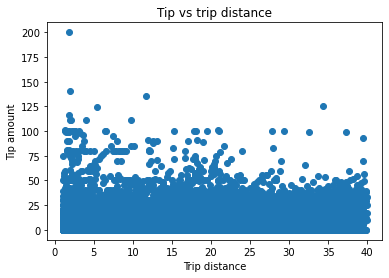

In [21]:
plt.scatter(df['trip_distance'], df['tip_amount'])
plt.title("Tip vs trip distance")
plt.xlabel("Trip distance")
plt.ylabel("Tip amount")
plt.savefig("TipvsTripDistance.png")
plt.show()
plt.close()

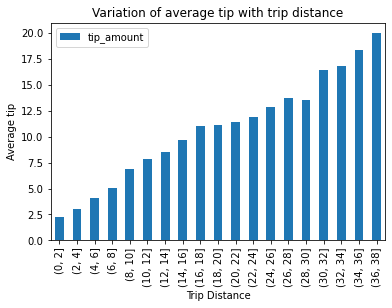

In [101]:
df['distance_bin'] = pd.cut(df['trip_distance'], list(range(0, 40, 2)))
df2 = df.groupby('distance_bin')[['tip_amount']].mean()
ax = df2.plot.bar()

ax.set_title('Variation of average tip with trip distance')
ax.set_xlabel('Trip Distance')
ax.set_ylabel('Average tip')
ax.figure.savefig('BarTipvsDistance.png')

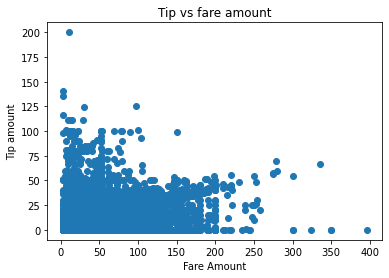

In [26]:
plt.scatter(df['fare_amount'], df['tip_amount'])
plt.title("Tip vs fare amount")
plt.xlabel("Fare Amount")
plt.ylabel("Tip amount")
plt.savefig("TipvsFareAmount.png")
plt.show()
plt.close()

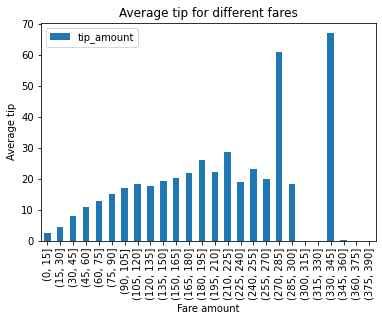

In [102]:
df['fare_bin'] = pd.cut(df['fare_amount'], list(range(0, 400, 15)))
df2 = df.groupby('fare_bin')[['tip_amount']].mean()
ax = df2.plot.bar()

ax.set_title('Average tip for different fares')
ax.set_xlabel('Fare amount')
ax.set_ylabel('Average tip')
ax.figure.savefig('BarTipvsFare.png')

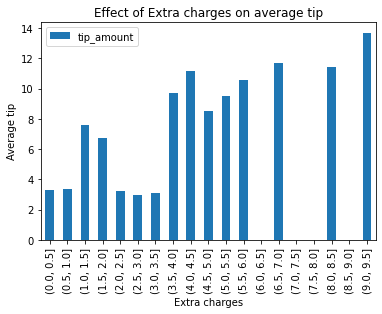

In [103]:
df['extra_bin'] = pd.cut(df['extra'], list(np.arange(0, 10, 0.5)))
df2 = df.groupby('extra_bin')[['tip_amount']].mean()
ax = df2.plot.bar()

ax.set_title('Effect of Extra charges on average tip')
ax.set_xlabel('Extra charges')
ax.set_ylabel('Average tip')
ax.figure.savefig('BarTipvsExtra.png')

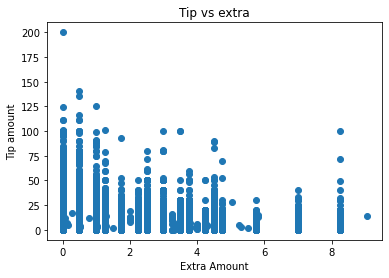

In [36]:
plt.scatter(df['extra'], df['tip_amount'])
plt.title("Tip vs extra")
plt.xlabel("Extra Amount")
plt.ylabel("Tip amount")
plt.savefig("TipvsExtraAmount.png")
plt.show()
plt.close()

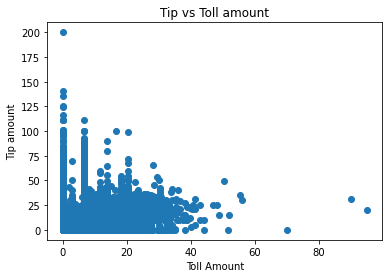

In [38]:
plt.scatter(df['tolls_amount'], df['tip_amount'])
plt.title("Tip vs Toll amount")
plt.xlabel("Toll Amount")
plt.ylabel("Tip amount")
plt.savefig("TipvsTollAmount.png")
plt.show()
plt.close()

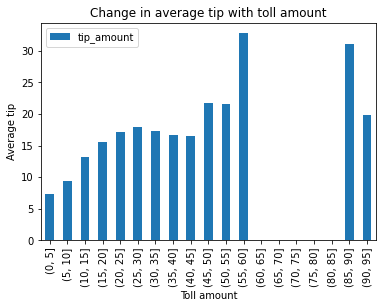

In [104]:
df['toll_bin'] = pd.cut(df['tolls_amount'], list(range(0, 100, 5)))
df2 = df.groupby('toll_bin')[['tip_amount']].mean()
ax = df2.plot.bar()

ax.set_title('Change in average tip with toll amount')
ax.set_xlabel('Toll amount')
ax.set_ylabel('Average tip')
ax.figure.savefig('BarTipvsToll.png')

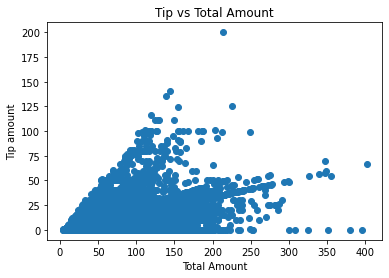

In [40]:
plt.scatter(df['total_amount'], df['tip_amount'])
plt.title("Tip vs Total Amount")
plt.xlabel("Total Amount")
plt.ylabel("Tip amount")
plt.savefig("TipvsTotalAmount.png")
plt.show()
plt.close()

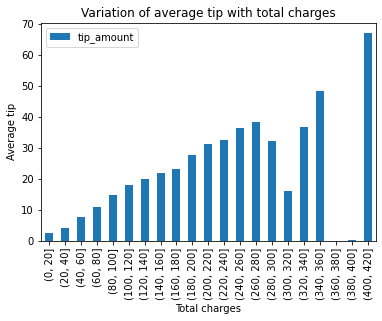

In [105]:
df['total_bin'] = pd.cut(df['total_amount'], list(range(0, 440, 20)))
df2 = df.groupby('total_bin')[['tip_amount']].mean()
ax = df2.plot.bar()

ax.set_title('Variation of average tip with total charges')
ax.set_xlabel('Total charges')
ax.set_ylabel('Average tip')
ax.figure.savefig('BarTipvsTotalAmount.png')

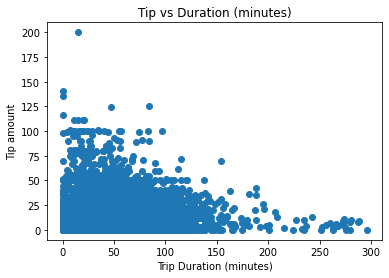

In [46]:
plt.scatter(df['duration'], df['tip_amount'])
plt.title("Tip vs Duration (minutes)")
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Tip amount")
plt.savefig("TipvsDuration.png")
plt.show()
plt.close()

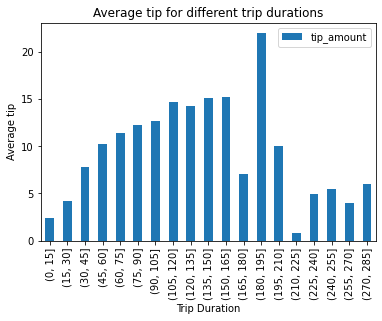

In [106]:
df['duration_bin'] = pd.cut(df['duration'], list(range(0,300, 15)))
df2 = df.groupby('duration_bin')[['tip_amount']].mean()
ax = df2.plot.bar()

ax.set_title('Average tip for different trip durations')
ax.set_xlabel('Trip Duration')
ax.set_ylabel('Average tip')
ax.figure.savefig('BarTipvsDuration.png')

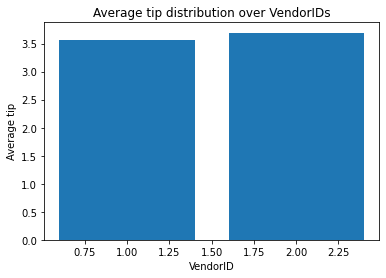

In [86]:
df2 = df.groupby('VendorID')[['tip_amount']].mean()
plt.bar(df2.index, df2['tip_amount'])
plt.title("Average tip distribution over VendorIDs")
plt.xlabel("VendorID")
plt.ylabel("Average tip")
plt.savefig("BarTipvsVendorID.png")
plt.show()
plt.close()

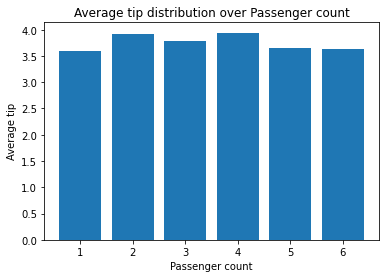

In [87]:
df2 = df.groupby('passenger_count')[['tip_amount']].mean()
plt.bar(df2.index, df2['tip_amount'])
plt.title("Average tip distribution over Passenger count")
plt.xlabel("Passenger count")
plt.ylabel("Average tip")
plt.savefig("BarTipvsPassengerCount.png")
plt.show()
plt.close()

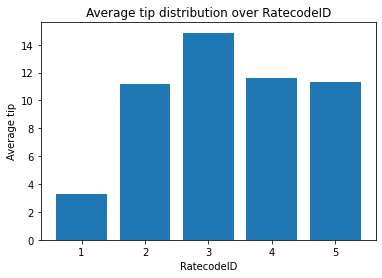

In [88]:
df2 = df.groupby('RatecodeID')[['tip_amount']].mean()
plt.bar(df2.index, df2['tip_amount'])
plt.title("Average tip distribution over RatecodeID")
plt.xlabel("RatecodeID")
plt.ylabel("Average tip")
plt.savefig("BarTipvsRatecodeID.png")
plt.show()
plt.close()

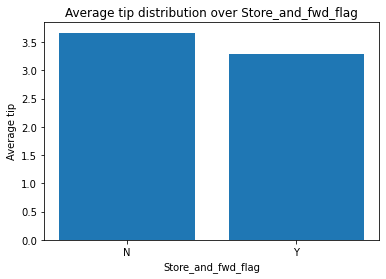

In [89]:
df2 = df.groupby('store_and_fwd_flag')[['tip_amount']].mean()
plt.bar(df2.index, df2['tip_amount'])
plt.title("Average tip distribution over Store_and_fwd_flag")
plt.xlabel("Store_and_fwd_flag")
plt.ylabel("Average tip")
plt.savefig("BarTipvsStore_and_fwd_flag.png")
plt.show()
plt.close()

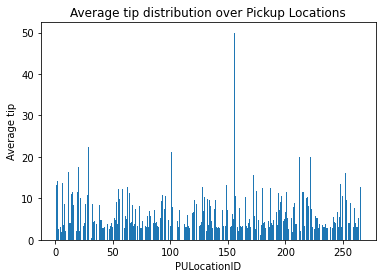

In [90]:
df2 = df.groupby('PULocationID')[['tip_amount']].mean()
plt.bar(df2.index, df2['tip_amount'])
plt.title("Average tip distribution over Pickup Locations")
plt.xlabel("PULocationID")
plt.ylabel("Average tip")
plt.savefig("BarTipvsPULocationID.png")
plt.show()
plt.close()

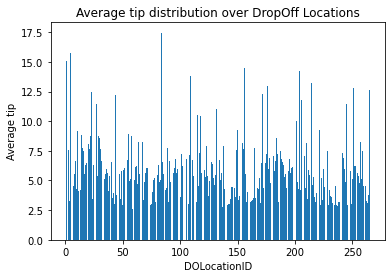

In [91]:
df2 = df.groupby('DOLocationID')[['tip_amount']].mean()
plt.bar(df2.index, df2['tip_amount'])
plt.title("Average tip distribution over DropOff Locations")
plt.xlabel("DOLocationID")
plt.ylabel("Average tip")
plt.savefig("BarTipvsDOLocationID.png")
plt.show()
plt.close()

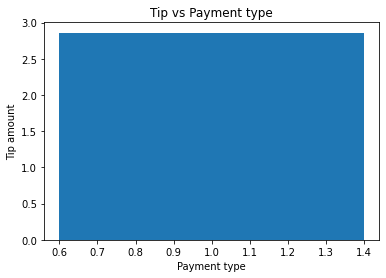

In [57]:
df2 = df.groupby('payment_type')[['tip_amount']].median()
plt.bar(df2.index, df2['tip_amount'])
plt.title("Tip vs Payment type")
plt.xlabel("Payment type")
plt.ylabel("Average tip")
plt.savefig("BarTipvsPayment_type.png")
plt.show()
plt.close()

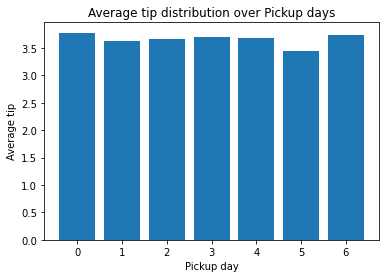

In [92]:
df2 = df.groupby('pickup_day')[['tip_amount']].mean()
plt.bar(df2.index, df2['tip_amount'])
plt.title("Average tip distribution over Pickup days")
plt.xlabel("Pickup day")
plt.ylabel("Average tip")
plt.savefig("BarTipvsPickup_day.png")
plt.show()
plt.close()

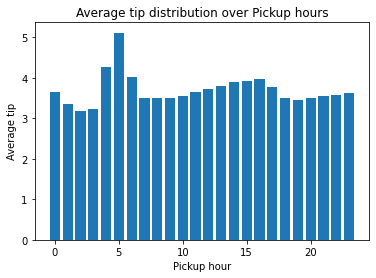

In [93]:
df2 = df.groupby('pickup_hour')[['tip_amount']].mean()
plt.bar(df2.index, df2['tip_amount'])
plt.title("Average tip distribution over Pickup hours")
plt.xlabel("Pickup hour")
plt.ylabel("Average tip")
plt.savefig("BarTipvsPickup_hour.png")
plt.show()
plt.close()

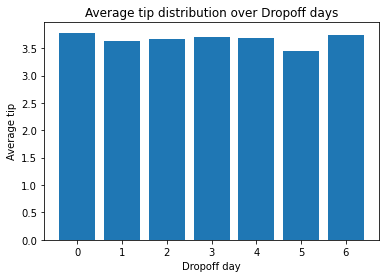

In [94]:
df2 = df.groupby('dropoff_day')[['tip_amount']].mean()
plt.bar(df2.index, df2['tip_amount'])
plt.title("Average tip distribution over Dropoff days")
plt.xlabel("Dropoff day")
plt.ylabel("Average tip")
plt.savefig("BarTipvsDropoff_day.png")
plt.show()
plt.close()

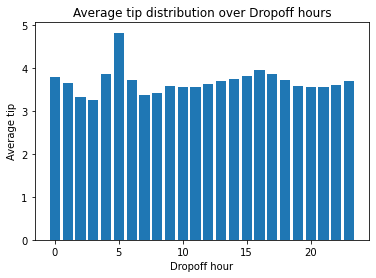

In [95]:
df2 = df.groupby('dropoff_hour')[['tip_amount']].mean()
plt.bar(df2.index, df2['tip_amount'])
plt.title("Average tip distribution over Dropoff hours")
plt.xlabel("Dropoff hour")
plt.ylabel("Average tip")
plt.savefig("BarTipvsDropoff_hour.png")
plt.show()
plt.close()

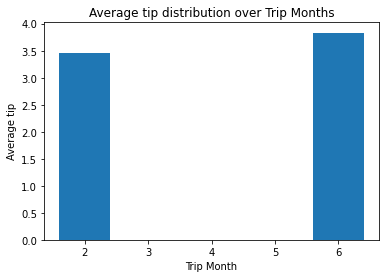

In [96]:
df2 = df.groupby('trip_month')[['tip_amount']].mean()
plt.bar(df2.index, df2['tip_amount'])
plt.title("Average tip distribution over Trip Months")
plt.xlabel("Trip Month")
plt.ylabel("Average tip")
plt.savefig("BarTipvsTrip_Month.png")
plt.show()
plt.close()

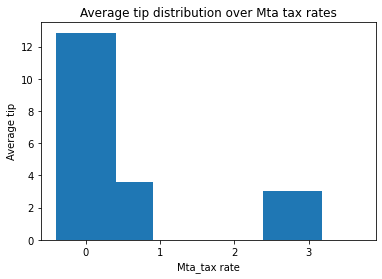

In [97]:
df2 = df.groupby('mta_tax')[['tip_amount']].mean()
plt.bar(df2.index, df2['tip_amount'])
plt.title("Average tip distribution over Mta tax rates")
plt.xlabel("Mta_tax rate")
plt.ylabel("Average tip")
plt.savefig("BarTipvsMta_tax-Cat.png")
plt.show()
plt.close()

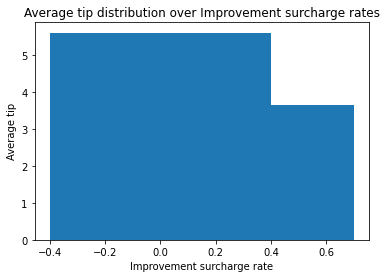

In [98]:
df2 = df.groupby('improvement_surcharge')[['tip_amount']].mean()
plt.bar(df2.index, df2['tip_amount'])
plt.title("Average tip distribution over Improvement surcharge rates")
plt.xlabel("Improvement surcharge rate")
plt.ylabel("Average tip")
plt.savefig("BarTipvsImprovement_surcharge-Cat.png")
plt.show()
plt.close()

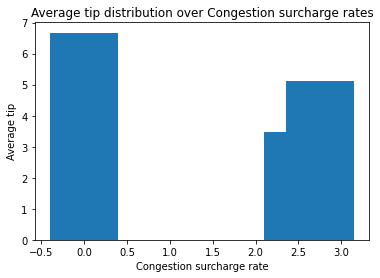

In [99]:
df2 = df.groupby('congestion_surcharge')[['tip_amount']].mean()
plt.bar(df2.index, df2['tip_amount'])
plt.title("Average tip distribution over Congestion surcharge rates")
plt.xlabel("Congestion surcharge rate")
plt.ylabel("Average tip")
plt.savefig("BarTipvsCongestion_surcharge-Cat.png")
plt.show()
plt.close()

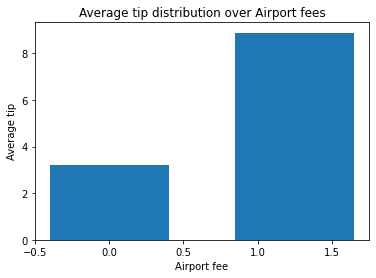

In [100]:
df2 = df.groupby('airport_fee')[['tip_amount']].mean()
plt.bar(df2.index, df2['tip_amount'])
plt.title("Average tip distribution over Airport fees")
plt.xlabel("Airport fee")
plt.ylabel("Average tip")
plt.savefig("BarTipvsAirport_fee-Cat.png")
plt.show()
plt.close()

In [ ]:
df.columns